<img align="left" src="https://www.taborelec.com/Pictures/logo.png">

# Download Waveforms to Segments

In [1]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
import os
import gc
import sys
srcpath = os.path.realpath('../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst

### Before we start

This example is designed to work both when there is a LAN based communication-service (usually on benchtop/desktop)<br>
And when there's no communication-service, and the user's application has access to hardware-modules in the PXI chassis.

In the first case, when there's a LAN communication, this example uses the class `TEVisaInst` from `tevisainst`.<br>

In the second case, this example uses the classes `TEProteusAdmin` and `TEProteusInst` from `teproteus`.

In [3]:
# Connect to instrument

inst = None
admin = None

conn_msg_str = ''

def disconnect():
    global inst
    global admin
    if inst is not None:
        try:
            inst.close_instrument()            
        except:
            pass
        inst = None
    if admin is not None:
        try:
            admin.close_inst_admin()
        except:
            pass
        admin = None
    gc.collect()

def connect_to_pxi_slot(slot_id):
    global inst
    global admin
    try:
        disconnect()        
        admin = TEProteusAdmin()
        admin.open_inst_admin()        
        inst = admin.open_instrument(slot_id, reset_hot_flag=True)
    except:
        pass

def connect_to_lan_server(ip_address):
    global inst
    try:
        disconnect()
        inst = TEVisaInst(ip_address, port=5025)
    except:
        pass

def connect(ipaddr_or_slotid):
    try:
        disconnect()
        if isinstance(ipaddr_or_slotid, str) and '.' in ipaddr_or_slotid:
            connect_to_lan_server(ipaddr_or_slotid)
        else:
            connect_to_pxi_slot(ipaddr_or_slotid)
    except:
        pass

addr_textbox = widgets.Text(
    value='',
    placeholder='IP Address or Slot Id',
    description='Address:',
    disabled=False
)

output = widgets.Output()

def print_conn_message(msg_str):
    global output
    global conn_msg_str
    with output:
        if len(conn_msg_str) > 0:
            print('\r', end='')
            print(' ' * len(conn_msg_str), end='')
            print('\r', end='')
        conn_msg_str = str(msg_str)
        if len(conn_msg_str) > 0:
            print(conn_msg_str, end='')

def on_button_connect_clicked(b):
    global inst
    global addr_textbox
    print_conn_message('')
    disconnect()
    if addr_textbox is not None:
        conn_str = addr_textbox.value
        if conn_str:
            print_conn_message('Connecting to {0} ..'.format(conn_str))
            connect(conn_str)
            print_conn_message('')
    if inst is not None:
        idn_str = inst.send_scpi_query('*IDN?')
        if idn_str:
            print_conn_message('Connected to: ' + idn_str.strip())
    
def on_button_disconnect_clicked(b):
    print_conn_message('')
    disconnect()

btn_connect = widgets.Button(description="Connect")
btn_disconnect = widgets.Button(description="Disconnect")

btn_connect.on_click(on_button_connect_clicked)
btn_disconnect.on_click(on_button_disconnect_clicked)

display(addr_textbox, btn_connect, btn_disconnect, output)

Text(value='', description='Address:', placeholder='IP Address or Slot Id')

Button(description='Connect', style=ButtonStyle())

Button(description='Disconnect', style=ButtonStyle())

Output()

### Paranoia Level

When sending a SCPI command to instrument, it is highlly recommended to send it as query with `*OPC?`.<br>
For example, instead of sending bare SCPI command `:OUTPUT ON`, send a compound query `:OUTPUT ON; *OPC?`<br>
In that way the user makes sure the execution of the command has been completed before sending the next command.

The class `TEProteusInst` from `teproteus` and the class `TEVisaInst` from `tevisainst` both have a method<br>
called `send_scpi_cmd(scpi_str, paranoia_level=None)` that sends the given SCPI string `scpi_str` to the instrument.<br>

The optional `paranoia_level` argument can receive the values 0, 1 or 2 where
 - 0 means: send `scpi_str` as a bare SCPI command.
 - 1 means: append `*OPC?` to the given `scpi_str`, send it as query, and read the response (which is "1").
 - 2 means: append `:SYST:ERR?` to the given, send it as query and read the response (the last system error).

If the optional `paranoia_level` argument is not given then a default paranoia-level (that the user can setup) is used.

The initial value of the default paranoia-level is 1.<br>
High paranoia-level (2) is good for debugging, because the system-error is checked after each SCPI command.     

In [4]:
# Set the default paranoia-level (0, 1 or 2)
inst.default_paranoia_level = 2 # good for debugging

# Clear error-list and reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

# Select Sampling-Clock Rate
sclk = 9e+9
print('Set sampling rate {0} Hz ..'.format(sclk))
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(sclk))

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Set sampling rate 9000000000.0 Hz ..
0, no error


In [5]:
# Get the model name
model = inst.send_scpi_query(":SYST:INF:MODel?")
print("Model: " + model)

# Get user's waveform format
resp = inst.send_scpi_query(":TRAC:FORMat?")
print("User's waveform format: " + resp)

# Infer width of wave-point in the user's waveform
if resp == 'U8':
    wpt_width = 8
elif resp == 'U16':
    wpt_width = 16
    
print("User's waveform format: {0} bits-per-point".format(wpt_width))

max_wpt = 2 ** wpt_width - 1
mid_wpt = max_wpt / 2.0
print('Max wave-point level: {0}'.format(max_wpt))
print('Mid wave-point level: {0}'.format(mid_wpt))

# Get number of channels
resp = inst.send_scpi_query(":INST:CHAN? MAX")
print("Number of channels: " + resp)
num_channels = int(resp)

# Get the maximal number of segments
resp = inst.send_scpi_query(":TRACe:SELect:SEGMent? MAX")
print("Max segment number: " + resp)
max_seg_number = int(resp)

# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))


Model: P9484M
User's waveform format: U16
User's waveform format: 16 bits-per-point
Max wave-point level: 65535
Mid wave-point level: 32767.5
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 4,286,578,688 wave-bytes


## Writing waveform data to segment

The command `:TRACE:DATA [<offset-in-bytes>] #<binary-header><binary-data>`  
writes the given block of binary data to the specified offset in the selected segment of the selected channel.

#### The header of the binary-data block
The SCPI protocol uses text-based messages, and the new-line character denotes end of a SCPI statement.<br>
In case of binary-data the sender must send a header that defines the size of the binary block before the data  
because the new-line character can be a part of the data.<br>

The header is composed of `'#'` character followed by a sequence of between 2 and 10 decimal digits, where the<br>
first digits denotes how many digits follows it (between 1 and 9) and the rest of the digits denote the size of the<br>
binary-block in bytes. For example, `#3256` denotes block of 256 bytes, and `#41024` denotes block of 1024 bytes.

### Simple example

Download waves to several segments and play different segment in each channel.  


In [6]:
# Build 12 waveforms

seglen = 81920
num_cycles = (1, 2, 4, 8)

waves = [ None for _ in range(12)]

for ii in range(4):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
    y = (np.sin(x) + 1.0) * mid_wpt
    y = np.round(y)
    y = np.clip(y, 0, max_wpt)
    if wpt_width == 16:
        waves[ii] = y.astype(np.uint16)
    else:
        waves[ii] = y.astype(np.uint8)
    
for ii in range(4):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
    y = np.sin(x)
    y = np.arcsin(y)* 2 * mid_wpt / np.pi + mid_wpt
    y = np.round(y)
    y = np.clip(y, 0, max_wpt)
    if wpt_width == 16:
        waves[ii + 4] = y.astype(np.uint16)
    else:
        waves[ii + 4] = y.astype(np.uint8)
    
for ii in range(4):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    
    x = np.linspace(start=0, stop=seglen, num=seglen, endpoint=False)
    y = np.fmod(x, cyclelen)
    y = (y <= cyclelen / 2) * max_wpt
    y = np.round(y)
    y = np.clip(y, 0, max_wpt)
    if wpt_width == 16:
        waves[ii + 8] = y.astype(np.uint16)
    else:
        waves[ii + 8] = y.astype(np.uint8)
 

In [7]:
# Download segments
for ii in range(num_channels):
    ichan = ii
    channb = ichan + 1
    segnum = ichan % 2 + 1
    wav = waves[ichan]
    print('Download wave to segment {0} of channel {1}'.format(segnum, channb))
    
    # Select channel
    cmd = ':INST:CHAN {0}'.format(channb)
    inst.send_scpi_cmd(cmd)
    
    # Define segment
    cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
    inst.send_scpi_cmd(cmd)
    
    # Select the segment
    cmd = ':TRAC:SEL {0}'.format(segnum)
    inst.send_scpi_cmd(cmd)
        
    # Send the binary-data:
    inst.write_binary_data(':TRAC:DATA', wav)
        
    resp = inst.send_scpi_query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))

    # Play the specified segment at the selected channel:
    cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
    inst.send_scpi_cmd(cmd)

    # Turn on the output of the selected channel:
    inst.send_scpi_cmd(':OUTP ON')
    
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

print()

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

del waves
del wav

Download wave to segment 1 of channel 1
0, no error
Download wave to segment 2 of channel 2
0, no error
Download wave to segment 1 of channel 3
0, no error
Download wave to segment 2 of channel 4
0, no error

0, no error


## Reading data from segment 

The query `:TRACE:DATA? <offset-in-bytes>,<size-in-bytes>` is used for reading  
the specified amount of data from the specified offset at the selected segment of the selected channel. 

The response from the instrument is of the form `#<binary-header><binary-block>`  
where the binary-header has the same formt as before. There is no need to add `*OPC?` in this case, because it is query. 

In [8]:
offset_in_bytes = 0

if wpt_width == 16:
    size_in_bytes = 2 * seglen
    data_type = np.uint16
else:
    size_in_bytes = seglen
    data_type = np.uint8

waves = [None for _ in range(num_channels)]

for ii in range(num_channels):
    ichan = ii
    channb = ichan + 1
    segnum = ichan % 2 + 1
    print('Read wave from segment {0} of channel {1}'.format(segnum, channb))
    
    # Select channel
    cmd = ':INST:CHAN {0}'.format(channb)
    inst.send_scpi_cmd(cmd)
    
    # Select segment
    cmd = ':TRAC:SEL {0}'.format(segnum)
    inst.send_scpi_cmd(cmd)
    
    # Allocate buffer
    wav = np.empty(seglen, dtype=data_type)
    
    # Read binary data
    cmd = ':TRAC:DATA? {0}, {1}'.format(offset_in_bytes, size_in_bytes)
    
    inst.read_binary_data(
        scpi_pref=cmd,
        out_array=wav,
        num_bytes=size_in_bytes)
    
    waves[ii] = wav
    wav = None
    
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

Read wave from segment 1 of channel 1
0, no error
Read wave from segment 2 of channel 2
0, no error
Read wave from segment 1 of channel 3
0, no error
Read wave from segment 2 of channel 4
0, no error


<IPython.core.display.Javascript object>


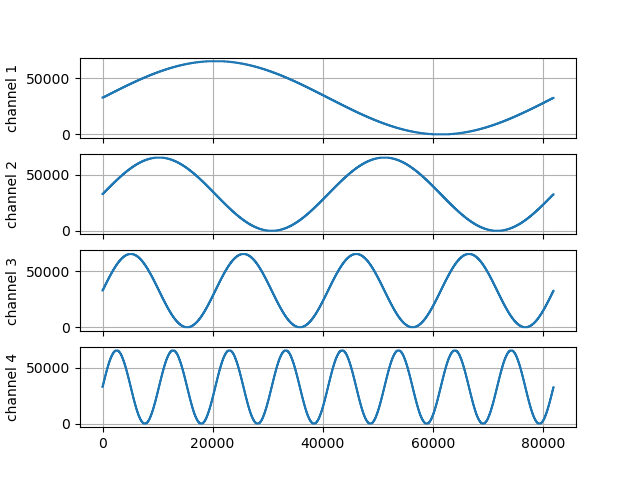

In [9]:
# Plot the waves
x = np.arange(seglen)

fig1, axs = plt.subplots(nrows=num_channels, ncols=1, sharex=True, num=1, clear=True)
for ii in range(num_channels):
    axs[ii].plot(x, waves[ii])
    axs[ii].set_ylabel('channel {0}'.format(ii + 1))
    axs[ii].grid(True)

plt.show()
del x, waves

## Use `:TRACE:DATA` command with *offset* parameter for large segment

The format of the [binary-header](#The-header-of-the-binary-data-block) limits the maximal block-size to $10^9-1$ bytes.

Therefore, when dealing with large segments, one should use the *offset* parameter <br>
of the `:TRACE:DATA` command, and write (or read) data in chunks (to varying offsets inside the segment).<br>

#### Important
For efficiency, the size of each chunk except the last one should be between about 1MB and a few MB <br>
where 1MB is $2^{20}=1024^2=1048576$ bytes, and both the chunk-size and the offset should be multiplications of 64.

In [10]:
channb = 1
segum = 1

totsize = (arbmem_capacity // 64) * 64
chunksize = min(2**20, totsize)
if wpt_width == 16:
    seglen  = totsize // 2
    chunklen = chunksize // 2
else:
    seglen  = totsize
    chunklen = chunksize

# Reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

# Set sampling rate
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(sclk))

# Select channel
cmd = ':INST:CHAN {0}'.format(channb)
inst.send_scpi_cmd(cmd)

# Define segment
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
inst.send_scpi_cmd(cmd)

# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd(cmd)

offset = 0
ncycles = 1

print()
msg = 'Wrote {0:,} bytes out of {1:,}'.format(offset, totsize)
print(msg, end='')

while offset < totsize:
    
    # prepare chunk of waveform data
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=chunklen, endpoint=False)
    y = (np.sin(x) + 1.0) * mid_wpt
    y = np.round(y)
    y = np.clip(y, 0, max_wpt)
    if wpt_width == 16:
        y = y.astype(np.uint16)
    else:
        y = y.astype(np.uint8)
    
    if totsize - offset < chunksize:
        chunksize = totsize - offset
        if wpt_width == 16:
            chunklen = chunksize // 2
        else:
            chunklen = chunksize
        y = y[0:chunklen]
            
    # Send the binary-data with *OPC? added to the beginning of its prefix.
    cmd = '*OPC?; :TRAC:DATA {0}'.format(offset)
    # Send the binary-data:
    inst.write_binary_data(cmd, y)
    
    offset = offset + chunksize
    ncycles = (ncycles % 1024) + 1
    
    # Print progress
    if len(msg) > 0:
        print('\r', end='') 
        print(' ' * len(msg), end='')
        print('\r', end='')
    msg = 'Wrote {0:,} bytes out of {1:,}'.format(offset, totsize)
    print(msg, end='')

print('\n')

del x, y

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Play the specified segment at the selected channel:
cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
inst.send_scpi_cmd(cmd)

# Turn on the output of the selected channel:
inst.send_scpi_cmd(':OUTP ON')


Wrote 4,286,578,688 bytes out of 4,286,578,688

0, no error


0

In [11]:
# Read the data in chunks

chunksize = min(2**20, totsize)
if wpt_width == 16:
    data_type = np.uint16
    chunklen = chunksize // 2
else:
    data_type = np.uint8
    chunklen = chunksize

wav = np.empty(chunklen, dtype=data_type)

offset = 0
ncycles = 1

print()
msg = 'Read {0:,} bytes out of {1:,}'.format(offset, totsize)
print(msg, end='')

while offset < totsize:
    
    # prepare chunk of waveform data (for comparison)
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=chunklen, endpoint=False)
    y = (np.sin(x) + 1.0) * mid_wpt
    y = np.round(y)
    y = np.clip(y, 0, max_wpt)
    if wpt_width == 16:
        y = y.astype(np.uint16)
    else:
        y = y.astype(np.uint8)
    
    if totsize - offset < chunksize:
        chunksize = totsize - offset
        if wpt_width == 16:
            chunklen = chunksize // 2
        else:
            chunklen = chunksize
        y = y[0:chunklen]
        wav = np.empty(chunklen, dtype=data_type)
    
    
    # Read chunk of binary data
    cmd = ':TRAC:DATA? {0},{1}'.format(offset, chunksize)
    inst.read_binary_data(
        scpi_pref=cmd,
        out_array=wav,
        num_bytes=chunksize)
    
    offset = offset + chunksize
    ncycles = (ncycles % 1024) + 1
    
    # Print progress
    if len(msg) > 0:
        print('\r', end='') 
        print(' ' * len(msg), end='')
        print('\r', end='')
    msg = 'Read {0:,} bytes out of {1:,}'.format(offset, totsize)
    print(msg, end='')

print('\n')
del x, y, wav

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


Read 4,286,578,688 bytes out of 4,286,578,688

0, no error


## Use `:TRACe:SEGMents[:DATA]` and `:TRACe:MEMory` for multiple segments

#### The command `:TRACe:SEGMents[:DATA] [<first-segment-number>] #<binary-header><binary-data>`
This command defines multiple simple segments in the segment-table of the selected channel.<br>

 - The binary-data consists of *N* `uint64` values with the lengths of *N* segments, expressed in **bytes** of wave-data<br>
   (in that aspect it differs from the `:TRACe:DEFine` command that receives the segment-length in points).
 - The *first-segment-number* is an optional argument (the default is 1).<br>

When the command is executed it first resets the segment-table of the selected channel (like `:TRACe:DELete:ALL`),<br>
and then defines *N* segments of the given lengths and consecutive segment-numbers starting from *first-segment-number*.<br>

The memory for the segments is allocated continuously **from the beginning of memory-space** (of the selected channel).<br>
Therefore it is possible to use `TRACe:MEMory` for downloading waveform data to all the *N* segments.<br>

It is still possible, of course, to write (or read) data from each segment with `:TRACe:DATA`, but if, for example,<br>
one defines a large number of relatively small segments, then writing the waveform data in chunks of 1MB can be faster.

#### The command `:TRACe:MEMory [<offset-in-bytes-of-wave-data>] #<binary-header><binary-data>`
This command (or query) is the same as `:TRACe[:DATA]  [<offset-in-bytes-of-wave-data>] #<binary-header><binary-data>`<br>
except that the offset, in case of `:TRACe:MEMory`, is from the beginning of the memory-space rather than the beginning<br>
of memory of the selected segment.

### Caution

If a segment size (in bytes of waveform data) is not divisible by 64, which is legal for fast segments only,<br>
then the location of the next segment in memory is at the first offset in the memory-space that is divisible by 64.<br>
It is the responsibility of the user to pad the gap when using `:TRACe:MEMory`.

In [12]:
numsegs = 256
first_seg_size = 256
delta_seg_size = 256
last_seg_size = first_seg_size + delta_seg_size * (numsegs - 1)
total_size = (first_seg_size + last_seg_size) * numsegs // 2

if wpt_width == 16:
    bpp = 2    
    total_length = total_size // 2
    first_seg_len = first_seg_size // 2
    delta_seg_len = delta_seg_size // 2
else:
    bpp = 1
    total_length = total_size
    first_seg_len = first_seg_size
    delta_seg_len = delta_seg_size
    
print('total-length: {0:,}, total-size: {1:,}'.format(total_length, total_size))

seg_sizes = np.zeros(numsegs, dtype=np.uint64)
for n in range(numsegs):
    seg_sizes[n] = np.uint64(first_seg_size + n * delta_seg_size)
    
# Reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

# Set sampling rate
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(sclk))

# Select channel 1
inst.send_scpi_cmd(':INST:CHAN 1')

if 'P948' in model:
    # In case of P9484/P9482 family the command :TRACe:SEGMent
    # expects a list of segment-lengths (in wave-points)
    # rather than a list of segment-sizes (in bytes)
    seg_lengths = seg_sizes // bpp
    inst.write_binary_data(':TRAC:SEGM', seg_lengths)
else:
    # Send the list of segment-sizes as binary-data
    inst.write_binary_data(':TRAC:SEGM', seg_sizes)

# Set normal timeout
inst.timeout = 10000

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Build waveform data for all segments
if wpt_width == 16:
    wavdat = np.empty(total_length, dtype=np.uint16)
else:
    wavdat = np.empty(total_length, dtype=np.uint8)

offset = 0
for iseg in range(numsegs):
    seglen = int(seg_sizes[iseg] // bpp)    
    x = np.linspace(
        start=0, stop=2 * np.pi, num=seglen, endpoint=False)
    y = (np.sin(x) + 1.0) * mid_wpt
    y = np.round(y)
    y = np.clip(y, 0, max_wpt)
    if wpt_width == 16:
        y = y.astype(np.uint16)
    else:
        y = y.astype(np.uint8)
            
    wavdat[offset: offset + seglen] = y
    offset = offset + seglen

    del x, y

# Write the waveform data from the beginning of the memory-space
inst.write_binary_data(':TRAC:MEM', wavdat)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Play the segment 1 at the selected channel:
inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')

# Turn on the output of the selected channel:
inst.send_scpi_cmd(':OUTP ON')

total-length: 4,210,688, total-size: 8,421,376
0, no error
0, no error


0

In [14]:
# Validations

# 1. Read back the whole data
offset_in_bytes = 0
size_in_bytes = total_size

if wpt_width == 16:
    data_type = np.uint16
    chunklen = size_in_bytes // 2
else:
    data_type = np.uint8
    chunklen = size_in_bytes

y = np.empty(chunklen, dtype=data_type)

cmd = ':TRAC:MEM? {0},{1}'.format(offset_in_bytes, size_in_bytes)
inst.read_binary_data(
        scpi_pref=cmd,
        out_array=y,
        num_bytes=size_in_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


# 2. Query segments lengths and compare to the lengths we've written
for iseg in range(numsegs):
    expected_len = int(seg_sizes[iseg] // bpp)
    resp = inst.send_scpi_query(':TRAC:SEL {0}; :TRAC:DEF:LENG?'.format(iseg + 1))
    try:
        actual_len = int(resp)
    except:
        actual_len = -1
    
    if actual_len != expected_len:
        msg = 'segment {0}: expected-length: {1}, actual-length: {2}'.format(iseg + 1, expected_len, actual_len)
        print(msg)
        break

# 3. Read the data of each segment and make sure it is as expected
offset = 0
for iseg in range(numsegs):
    seglen = int(seg_sizes[iseg] // bpp)
    
    wexp = y[offset: offset + seglen]
    
    offset_in_bytes = offset * bpp
    size_in_bytes = seglen * bpp
    cmd = ':TRAC:MEM? {0},{1}'.format(offset_in_bytes, size_in_bytes)
    
    wact = np.empty(seglen, dtype=data_type)
    inst.read_binary_data(
        scpi_pref=cmd,
        out_array=wact,
        num_bytes=size_in_bytes)
    
    if not np.array_equal(wexp,wact):
        msg = 'Comparison failed on segment {0} (length {1}).'.format(iseg + 1,seglen )
        print(msg)
        break
    
    offset = offset + seglen
    del wact, wexp

0, no error


In [15]:
# Change the segment that being played in channel 1,
# and play all segments one after the other with some time-delay

for iseg in range(numsegs):    
    cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(iseg + 1)
    inst.send_scpi_cmd(cmd)
    time.sleep(0.5)   


In [16]:
# Disconnect
print_conn_message('')
disconnect()